# S1 vs s2 Conditional GAN - 28/1/20

As mentioned before, s1 and s2 are important characteristics to correctly model. Therefore the following script will create a conditional GAN, using s1 for dark matter at 50KeV to 200KeV in 50KeV intervals. It trains on 50,100 and 150 KeV, then tests the accuracy on these three as well as 200, to check the ability to extrapolate. 

This is the most veratile code skeleton produced this semester for several reasons. 
1) We are teting the ability to extrapolate, and whether it can reproduce distributions at unseen energies. 

2) We are dynamically saving the distribution. This means even if the neural not gets 'kicked out' the optimal distribution, we will have saved the correct weighting of nodes.

The method used to calcaulate the accuracy is the Kolmogorov Smirnov test.




In [29]:
pip install uproot

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
cd gdrive/My\ Drive/Masters_Project/dark_matter_7_12_19

[Errno 2] No such file or directory: 'gdrive/My Drive/Masters_Project/dark_matter_7_12_19'
/content/gdrive/My Drive/Masters_Project/dark_matter_7_12_19


In [0]:
#cd gdrive/My\ Drive/masters_project/dark_matter_7_12_19

Here we will extract some root files, most will be used to train the GAN, then one will be used to 'validate' the GAN.

Currently, we will use 50, 150, and 250 to train and 100 and 200 to validate.

In [0]:
import uproot
import pandas
import numpy as np
import matplotlib.pyplot as plt

tree50 = uproot.open("dark_matter_runs_50kev.root")["dstree"]
tree100 = uproot.open("dark_matter_100kev_v1.root")["dstree"]
tree150 = uproot.open("dark_matter_runs_150kev.root")["dstree"]
tree200 = uproot.open("dark_matter_runs_200kev.root")["dstree"]

In [34]:
tree50.show()

ev                         (no streamer)              asdtype('>i4')
pdg                        (no streamer)              asdtype('>i4')
ene0                       (no streamer)              asdtype('>f4')
s1ene                      (no streamer)              asdtype('>f4')
s2ene                      (no streamer)              asdtype('>f4')
veto_visene                (no streamer)              asdtype('>f4')
mu_visene                  (no streamer)              asdtype('>f4')
vetoene                    (no streamer)              asdtype('>f4')
muene                      (no streamer)              asdtype('>f4')
tpcene                     (no streamer)              asdtype('>f4')
x                          (no streamer)              asdtype('>f4')
y                          (no streamer)              asdtype('>f4')
z                          (no streamer)              asdtype('>f4')
ene                        (no streamer)              asdtype('>f4')
r                          (no str

The Variable is input here to try to make the code reusable and as general as possible.

In [0]:
#Variables to investigate
variables = ["s1","s2"]
#List containing the variables
truedata = [tree50,tree100,tree150,tree200]

energies = [50,100,150,200]
train_var = [50.,100.,150.]
colours = ['red','green','blue','purple']

num_train = int(1e3)
noise_size = 1000

#Pseudocode
def get_min_and_max(variables, truedata):
  returnarray = []
  for i in range(len(variables)):
    returnarray.append([0,max(np.array(truedata[-1].array(f"{variables[i]}")))])
  return returnarray

  #Return a array of arrays
def get_variables(truedata, variables, ranges):
  variabledata = []
  for i in range(len(variables)):
    eachvariable = []
    for j in range(len(truedata)):
      eachvariable.append(np.array(truedata[j].array(f"{variables[i]}"))/ranges[i][1])
    variabledata.append(eachvariable)
  return variabledata

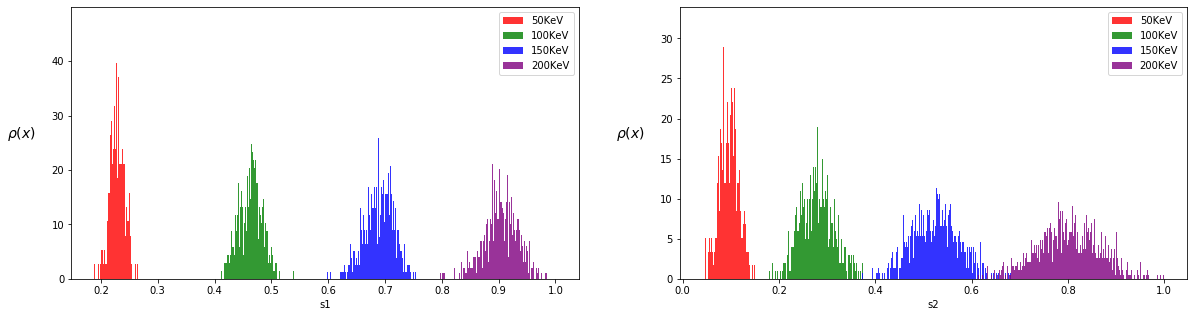

In [36]:
ranges = get_min_and_max(variables,truedata)

#Array normalised, [which variable][which energy]
variableArray = get_variables(truedata, variables, ranges)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
for i in range(len(variableArray[0])):
  ax1.hist(variableArray[0][i], density = True, bins = 205, alpha = 0.8, label = f"{energies[i]}KeV",color=f"{colours[i]}")

  ax1.set_xlabel(f"{variables[0]}")
  ax1.set_ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
  ax1.legend(loc="upper right", fontsize=10)

  ax2.hist(variableArray[1][i], density = True, bins = 205, alpha = 0.8, label = f"{energies[i]}KeV",color=f"{colours[i]}")

  ax2.set_xlabel(f"{variables[1]}")
  ax2.set_ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
  ax2.legend(loc="upper right", fontsize=10)
  

In [0]:
from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate
from keras.models     import Model, Sequential, load_model
from keras.optimizers import Adam, SGD

import keras.backend as K
d_do = 0.2
g_nodes = 120
d_nodes = 120
g_do = 0.2
#Input of GEN VALUE
d1_in = Input((2,))
d1 = Dense(d_nodes, activation="relu")(d1_in)
d1 = Dropout(d_do)(d1)

#Input of parameter = energy
hyper_in = Input((1,))
d2 = Dense(d_nodes, activation="relu")(hyper_in)
d2 = Dropout(d_do)(d2)

dc = Concatenate()([d1, d2])
dc = Dense(g_nodes , activation="relu")(dc)
dc = Dropout(d_do)(dc)
dc = Dense(g_nodes , activation="relu")(dc)
dc = Dropout(d_do)(dc)
dc = Dense(g_nodes , activation="relu")(dc)
dc = Dropout(d_do)(dc)
dc = Dense(g_nodes , activation="relu")(dc)
dc = Dropout(d_do)(dc)
dc = Dense(g_nodes , activation="relu")(dc)
#dc = LeakyReLU(0.2)(dc)
dc = Dropout(d_do)(dc)
dc = Dense(g_nodes , activation="relu")(dc)
#dc = LeakyReLU(0.2)(dc)
dc = Dropout(d_do)(dc)
dc = Dense(2, activation="softmax")(dc)

dc = Model(name="Discriminator", inputs=[d1_in, hyper_in], outputs=[dc])
dc.compile(loss="categorical_crossentropy", optimizer=Adam(0.001, beta_1=0.1), metrics=["accuracy"])
# 0.0005, beta_1=0.5
dc.summary()

#INPUT OF NOISE TO GENERATOR
g1_in = Input((noise_size,))
g1 = Dense(g_nodes, activation="relu")(g1_in)
g1 = Dropout(g_do)(g1)
g1 = BatchNormalization()(g1)
g1 = Dense(g_nodes, activation="relu")(g1)

#INPUT OF HYPERPARAM
g2 = Dense(g_nodes, activation="relu")(hyper_in)

gc = Concatenate()([g1, g2])
gc = BatchNormalization()(gc)
gc = Dropout(g_do)(gc)
gc = Dense(g_nodes, activation="relu")(gc)
gc = Dropout(g_do)(gc)
gc = Dense(g_nodes, activation="relu")(gc)
gc = Dropout(g_do)(gc)
gc = Dense(g_nodes, activation="relu")(gc)
gc = Dropout(g_do)(gc)
g1 = Dense(g_nodes, activation="relu")(g1)
gc = Dense(2, activation="linear")(gc)

gc = Model(name="Generator", inputs=[g1_in, hyper_in], outputs=[gc])
gc.summary()


gan_out = dc([gc([g1_in, hyper_in]), hyper_in])
gan = Model([g1_in, hyper_in], gan_out, name="GAN")
dc.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.001, beta_1=0.1), metrics=["accuracy"])
gan.summary()

In [0]:
#  Train GAN
rel_batch_size = 1
max_D_itrs_per_G_itr_e80 = 2
max_D_itrs_per_G_itr_e52 = 3

In [0]:
def plot_points_GAN (gen_data, train_DS_s1ene_50, train_DS_s1ene_100,train_DS_s1ene_150,datapoints1,datapoints2,minloss_given, epoch, batch_size, d_acc) :
    minloss = minloss_given
    s1 = np.asarray(gen_DS)[:,0]
    s2 = np.asarray(gen_DS)[:,1]

    gen_class_length = int(gen_DS.shape[0]/3)
    gen_data_50_s1 = s1[:gen_class_length                    ]
    gen_data_100_s1 = s1[gen_class_length  :2*gen_class_length]
    gen_data_150_s1 = s1[2*gen_class_length:3*gen_class_length]


    gen_data_50_s2 = s2[:gen_class_length                    ]
    gen_data_100_s2 = s2[gen_class_length  :2*gen_class_length]
    gen_data_150_s2 = s2[2*gen_class_length:3*gen_class_length]


    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    fig.suptitle(f"s1 and s2 from a 2D cGAN at Epoch {epoch} and batch size {batch_size}")
    #y_max, x, _ = plt.hist(train_DS_s1ene_50,range = (0,70), density = True, bins = 205, alpha = 0.4, label = "50KeV", color='blue')
    trues1_50 = ax1.hist(train_DS_s1ene_50*div1,range = (rangemins1,rangemaxs1), density = True, bins = 205, alpha = 0.4, label = "50KeV", color='blue')
    trues1_100 = ax1.hist(train_DS_s1ene_100*div1,range = (rangemins1,rangemaxs1), density = True, bins = 205, alpha = 0.4, label = "100KeV", color='red')
    trues1_150 = ax1.hist(train_DS_s1ene_150*div1,range = (rangemins1,rangemaxs1), density = True, bins = 205, alpha = 0.4, label = "150KeV",color='green')

    gens1_50 = ax1.hist(gen_data_50_s1*div1,range = (rangemins1,rangemaxs1), density = True, bins = 205, color='blue')
    gens1_100 = ax1.hist(gen_data_100_s1*div1,range = (rangemins1,rangemaxs1), density = True, bins = 205, color='red')
    gens1_150 = ax1.hist(gen_data_150_s1*div1,range = (rangemins1,rangemaxs1), density = True, bins = 205, color='green')


    ax1.set_xlabel("s1 Energy")
    ax1.set_ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
    #ax1.text(60,0.75*0.8,f"Epochs: {e}")
    #ax1.text(60,0.65*0.8,f"Batch Size: {batch_size}")

    trues2_50 = ax2.hist(train_DS_s2ene_50*div2,range = (rangemins2,rangemaxs2), density = True, bins = 205, alpha = 0.4, label = "50keV", color='blue')
    trues2_100 = ax2.hist(train_DS_s2ene_100*div2,range = (rangemins2,rangemaxs2), density = True, bins = 205, alpha = 0.4, label = "100keV", color='red')
    trues2_150 = ax2.hist(train_DS_s2ene_150*div2,range = (rangemins2,rangemaxs2), density = True, bins = 205, alpha = 0.4, label = "150keV",color='green')


    gens2_50 = ax2.hist(gen_data_50_s2*div2,range = (rangemins2,rangemaxs2), density = True, bins = 205, color='blue')
    gens2_100 = ax2.hist(gen_data_100_s2*div2,range = (rangemins2,rangemaxs2), density = True, bins = 205, color='red')
    gens2_150 = ax2.hist(gen_data_150_s2*div2,range = (rangemins2,rangemaxs2), density = True, bins = 205, color='green')


    ax2.set_xlabel("s2 Energy")
    ax2.set_ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
    #ax2.title(f"s2 from a 2D cGAN at Epoch {e} and batch size {batch_size}")
    #ax2.text(8.5,0.75*5,f"Epochs: {e}")
    #ax2.text(8.5,0.65*5,f"Batch Size: {batch_size}")


    trues1_200 = ax1.hist(train_DS_s1ene_200*div1,range = (1500,2250), density = True, bins = 205, alpha = 0.4, color='purple', label = '200keV')
    gens1_200 = ax1.hist(datapoints1*div1,range = (1500,2250), density = True, bins = 205, color='purple')
    trues2_200 = ax2.hist(train_DS_s2ene_200*div2,range = (17500,30000), density = True, bins = 205, alpha = 0.4, color='purple', label = '200keV')
    gens2_200 = ax2.hist(datapoints2*div2,range = (17500,30000), density = True, bins = 205, color='purple')
    
    ax1.legend(loc="upper right", fontsize=10)
    ax2.legend(loc="upper right", fontsize=10)

    #Check difference
    
    diffs1_200 = trues1_200[0] - gens1_200[0]
    diffs2_200 = trues2_200[0] - gens2_200[0]
    diffs1_150 = trues1_150[0] - gens1_150[0]
    diffs2_150 = trues2_150[0] - gens2_150[0]
    diffs1_100 = trues1_100[0] - gens1_100[0]
    diffs2_100 = trues2_100[0] - gens2_100[0]
    #diffs1_50 = trues1_50[0] - gens1_50[0]
    diffs2_50 = trues2_50[0] - gens2_50[0]
    sum_diff = 0
    for i in range(len(diffs1_50)):
      sum_diff += abs(diffs1_50[i]) + abs(diffs2_50[i]) + abs(diffs1_100[i]) + abs(diffs2_100[i]) + abs(diffs1_150[i]) + abs(diffs2_150[i])+ abs(diffs1_200[i]) + abs(diffs2_200[i])
    #If statement
    if sum_diff < minloss:
      #save weights
      print("SAVING")
      gc.save("2D_s1_s2.h5")
      minloss = sum_diff

    plt.show()
    return minloss

In [0]:
#  Train GAN
#range_min, range_max = 0, 70
#range_width = 70
#plot_resolution = 200
epochs     = 15000
batch_size = 1000
minloss = 1000000

real_loss = []
real_acc = []
epoch_no = []
def update_batch_size (gen_DS, e) :
    global batch_size
    #batch_size = min(max(batch_size, 100+int((e+1)/10.)), num_train)
    
def get_noise (train_var, batch_size):
  hyperp = []
  for i in range(len(train_var)):
    hyperp.append(np.full(fill_value=train_var[0], shape=(batch_size, 1)))
    flat_list = [item for hyperp in l for item in hyperp]
    noise = np.random.normal(size=(len(train_var)*batch_size, noise_size))
    return noise, flat_list

def get_train_data (train_var, batch_size,variableArray) :

    rannum1 = np.random.randint(0, len(train_DS_s1ene_50), batch_size)
    batch = []
    #Array normalised, [which variable][which energy]
    for i in range(len(variableArray[0])):
      batch_s11 = variablearray[0][i][rannum1].reshape(batch_size)
      batch_s21 = variablearray[0][i][rannum1].reshape(batch_size)
      batch_1 = np.matrix([batch_s11,batch_s21]).T
      batch_1 = np.array(batch_1)
      batch.append[batch_1]
    
    hyperp = []
    for i in range(len(train_var)):
      hyperp.append(np.full(fill_value=train_var[0], shape=(batch_size, 1)))
    flat_list = [item for hyperp in l for item in hyperp]
    return np.concatenate(batch), flat_list
  
epochs_saved = []
for e in range(epochs) :
    noise, noise_hyperparams    = get_noise(train_var, batch_size)
    batch_DS, batch_hyperparams = get_train_data(train_var, batch_size,variableArray)
    gen_DS   = gc.predict([noise, noise_hyperparams])
    real_label  = np.array([[1., 0.] for i in range(len(train_var)*batch_size)])
    fake_label  = np.array([[0., 1.] for i in range(len(train_var)*batch_size)])
    train_label = np.array([[1., 0.] for i in range(len(train_var)*batch_size)])
    X  = np.concatenate([batch_DS  , gen_DS    ])
    Xh = np.concatenate([batch_hyperparams  , noise_hyperparams    ])
    Y = np.concatenate([real_label, fake_label])
    W = np.concatenate([np.ones(shape=(batch_DS.shape[0],)), np.full(fill_value=rel_batch_size, shape=(gen_DS.shape[0],))])
    
    dc.trainable = True
    d_loss, d_acc = dc.train_on_batch([X, Xh], Y, sample_weight=W)

        
    noise, noise_hyperparams = get_noise(train_var, batch_size)
    dc.trainable = False
    gan.train_on_batch([noise, noise_hyperparams], train_label)
    
    if e == 0 or (e+1) % 200 == 0 :
        noise, noise_hyperparams = get_noise((train_var, batch_size)
        gen_DS = gc.predict([noise, noise_hyperparams])
        hyperparams = np.full(fill_value=200, shape=(100000, 1))
        z = np.random.normal(size=(1000, noise_size))
        datapoints1 = gc.predict([z, hyperparams])[:,0]
        datapoints2 = gc.predict([z, hyperparams])[:,1]
        minloss = plot_points_GAN(
            gen_DS,
            train_DS_s1ene_50,
            train_DS_s1ene_100,
            train_DS_s1ene_150,
            datapoints1,
            datapoints2,
            minloss,
            epoch=e+1, 
            batch_size=batch_size, 
            d_acc=dc.evaluate([X, Xh], Y, sample_weight=W, verbose=0)[1])
        update_batch_size(gen_DS, e)
        epoch_no.append(e)
        real_loss.append(d_loss)
        real_acc.append(d_acc)
        epochs_saved.append(e+1)

In [0]:
#Print the predicted for a range
final_gc = load_model("2D_s1_s2.h5", compile = False)
masses = [50.,100.,150.,200.,]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)

colors=['red','blue','green','purple']


ax1.hist(train_DS_s1ene_50*div1, density = True, bins = 205, alpha = 0.4, label = "50KeV",color = colors[0])
ax1.hist(train_DS_s1ene_100*div1, density = True, bins = 205, alpha = 0.4, label = "100KeV",color = colors[1])
ax1.hist(train_DS_s1ene_150*div1, density = True, bins = 205, alpha = 0.4, label = "150KeV",color = colors[2])
ax1.hist(train_DS_s1ene_200*div1, density = True, bins = 205, alpha = 0.4, label = "200KeV",color = colors[3])

ax2.hist(train_DS_s2ene_50*div2,density = True, bins = 205, alpha = 0.4, label = "50KeV",color = colors[0])
ax2.hist(train_DS_s2ene_100*div2, density = True, bins = 205, alpha = 0.4, label = "100KeV",color = colors[1])
ax2.hist(train_DS_s2ene_150*div2, density = True, bins = 205, alpha = 0.4, label = "150KeV",color = colors[2])
ax2.hist(train_DS_s2ene_200*div2, density = True, bins = 205, alpha = 0.4, label = "200KeV",color = colors[3])


for i in range(len(masses)):
  hyperparams = np.full(fill_value=masses[i], shape=(100000, 1))
  z = np.random.normal(size=(10000, noise_size))
  datapoints1 = final_gc.predict([z, hyperparams])[:,0]
  datapoints2 = final_gc.predict([z, hyperparams])[:,1]
  ax1.hist(datapoints1*div1, density = True, bins = 205, color = colors[i])
  ax2.hist(datapoints2*div2, density = True, bins = 205, color = colors[i])
  ax1.legend(loc="upper right", fontsize=10)
  ax2.legend(loc="upper right", fontsize=10)
  ax2.set_xlabel("S2")
  ax2.set_ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
  ax1.set_xlabel("S1")
  ax1.set_ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")

plt.show()
  

In [0]:
del epoch_no[0]
del real_loss[0]
del real_acc[0]
h3 = plt.plot(epoch_no,real_loss, color = 'blue', label = "Loss")
h4 = plt.plot(epoch_no,real_acc, color = 'orange', label = "Accuracy")
plt.xlabel("Epoch number", size=14, labelpad=10)
plt.ylabel("Loss", size=14, labelpad=20, rotation="vertical")
plt.title(f"Disciminator variables with batch size {batch_size} for s1 vs s2")
plt.legend(loc="center right", fontsize=10)
plt.show()

In [0]:
'''        
        #Graph the two distributions and pick the best one
        hyperparams = np.full(fill_value=200, shape=(100000, 1))
        z = np.random.normal(size=(1000, noise_size))
        datapoints1 = gc.predict([z, hyperparams])[:,0]
        datapoints2 = gc.predict([z, hyperparams])[:,1]
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_figheight(5)
        fig.set_figwidth(20)

        trues1 = ax1.hist(train_DS_s1ene_200*div1,range = (1500,2250), density = True, bins = 205, alpha = 1, color='red', label = 'G4 Data')
        gens1 = ax1.hist(datapoints1*div1,range = (1500,2250), density = True, bins = 205, alpha = 0.4, color='red', label = 'Generated Data')
        trues2 = ax2.hist(train_DS_s2ene_200*div2,range = (17500,30000), density = True, bins = 205, alpha = 1, color='red', label = 'G4 Data')
        gens2 = ax2.hist(datapoints2*div2,range = (17500,30000), density = True, bins = 205, alpha = 0.4, color='red', label = 'Generated Data')
        #Check difference
        
        diffs1 = trues1[0] - gens1[0]
        diffs2 = trues2[0] - gens2[0]
        sum_diff = 0
        for i in range(len(diffs1)):
          sum_diff += abs(diffs1[i]) + abs(diffs2[i])
        #If statement
        if sum_diff < minloss:
          #save weights
          gc.save("2D_s1_s2.h5")
          minloss = sum_diff'''